In [81]:
import random
import pandas as pd
import numpy as np
import os
import librosa

import pickle

from tqdm.auto import tqdm

from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import OneHotEncoder

import warnings
warnings.filterwarnings(action='ignore') 

In [82]:
CFG = {
    'SR':16000,
    'N_MFCC':32, # MFCC 벡터를 추출할 개수
    'SEED':41
}

In [83]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(CFG['SEED']) # Seed 고정

In [84]:
audio_data_path = 'audio_data'
audio_train_data_path = os.path.join(audio_data_path,'train')
audio_test_data_path = os.path.join(audio_data_path,'test')
train_df = pd.read_csv(os.path.join(audio_data_path,'train.csv'))
test_df = pd.read_csv(os.path.join(audio_data_path,'test.csv'))

In [85]:
def get_mfcc_feature(df, data_type, save_path):
    # Data Folder path
    root_folder = './audio_data'
    if os.path.exists(save_path):
        print(f'{save_path} is exist.')
        return
    features = []
    for uid in tqdm(df['SegmentId']):
        root_path = os.path.join(root_folder, data_type)
        uid += '.wav'
        path = os.path.join(root_path, uid)

        # librosa패키지를 사용하여 wav 파일 load
        y, sr = librosa.load(path, sr=CFG['SR'])
        
        # mfcc
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=CFG['N_MFCC'])

        y_feature = []
        # 추출된 MFCC들의 평균을 Feature로 사용
        for e in mfcc:
            y_feature.append(np.mean(e))
        features.append(y_feature)
    
    # 기존의 자가진단 정보를 담은 데이터프레임에 추출된 오디오 Feature를 추가
    mfcc_df = pd.DataFrame(features, columns=['mfcc_'+str(x) for x in range(1,CFG['N_MFCC']+1)])
    df = pd.concat([df, mfcc_df], axis=1)
    df.to_csv(save_path, index=False)
    print('Done.')

In [86]:
get_mfcc_feature(train_df, 'train', 'preprocessing_data/train_mfcc_data.csv')
get_mfcc_feature(test_df, 'test', 'preprocessing_data/test_mfcc_data.csv')


Done.



Done.


In [87]:
# wav 파일의 MFCC Feature와 상태정보를 합친 학습데이터를 불러옵니다.
train_df = pd.read_csv('preprocessing_data/train_mfcc_data.csv')
test_df = pd.read_csv('preprocessing_data/test_mfcc_data.csv')

In [88]:
# 학습데이터를 모델의 input으로 들어갈 x와 label로 사용할 y로 분할
train_x = train_df.drop(columns=['Unnamed: 0', 'SegmentId','time','Valence','Arousal','Emotion'])
train_y = train_df['Emotion']

In [89]:
train_x

,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,...,mfcc_23,mfcc_24,mfcc_25,mfcc_26,mfcc_27,mfcc_28,mfcc_29,mfcc_30,mfcc_31,mfcc_32
0,-379.964142,109.689522,8.409287,14.947894,-10.617918,-1.278166,-9.656478,-3.804506,1.033329,2.386927,...,-0.390324,2.626545,0.437545,2.089825,0.171152,5.063381,3.834727,1.973997,-3.659752,-1.247434
1,-316.165100,96.198570,-13.874292,23.989883,-16.052597,6.285239,-17.207815,-9.229585,-1.843399,-1.561611,...,2.732685,5.995924,5.040682,8.586355,6.141405,8.720468,8.573661,10.320451,7.674820,4.114799
2,-354.932220,124.622856,13.342740,26.263084,-8.358158,12.222456,-5.986515,-3.229876,0.693578,1.045244,...,-0.242917,0.397124,4.878927,5.264405,2.994150,2.870259,0.314687,2.809367,-0.628893,3.489642
3,-385.279846,118.912277,13.351930,38.183296,4.666812,5.982921,-3.649076,-1.012486,1.646602,-5.259025,...,2.936629,-0.579203,-1.418086,2.701938,-0.128480,-0.650981,0.222955,1.449542,-1.601669,-0.025312
4,-351.163513,109.502029,4.125424,35.244442,-8.720855,-9.711296,-7.127413,-2.853542,0.309397,1.081380,...,3.420357,6.290679,3.681709,5.164492,3.685917,7.506263,7.469996,7.370858,6.551222,5.917849
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10764,-307.079376,110.748199,3.071705,26.098019,1.365202,-11.161897,-9.812368,2.677070,-12.284978,1.411189,...,-4.210361,-1.421704,-2.658003,1.054526,-3.188072,0.515963,0.066960,0.752482,-1.321549,-3.410846
10765,-239.924500,72.984070,-18.580250,-6.845965,-45.430508,0.680878,-8.975255,-18.834259,-0.833172,-0.091480,...,6.675857,10.649000,7.589522,8.607011,2.216211,7.668085,-0.767406,2.716651,-3.422506,4.849663
10766,-333.780945,95.989861,-14.832805,15.677377,-13.445169,-0.555010,-22.605991,-9.910537,-7.518460,-5.561435,...,-3.285286,1.564119,6.515084,10.374402,8.091890,14.184700,12.203178,19.104069,6.390728,4.591437
10767,-339.677338,118.469772,10.663605,37.051121,-10.494557,11.044798,-7.957495,-2.332411,-4.041122,-2.618592,...,-0.823455,1.826434,-0.563071,3.543955,-0.973314,3.040696,3.090068,4.243995,0.834076,1.139718


In [90]:
train_y

0              neutral
1                happy
2              neutral
3              neutral
4              neutral
             ...      
10764          neutral
10765            angry
10766    happy;neutral
10767          neutral
10768          neutral
Name: Emotion, Length: 10769, dtype: object

In [91]:
model = MLPClassifier(random_state=CFG['SEED']) # Sklearn에서 제공하는 Multi-layer Perceptron classifier 사용
model.fit(train_x, train_y) # Model Train

MLPClassifier(random_state=41)

In [92]:
# 위의 학습데이터를 전처리한 과정과 동일하게 test data에도 적용
test_x = test_df.drop(columns=['Unnamed: 0', 'SegmentId','time','Valence','Arousal','Emotion'])
test_y = test_df['Emotion']

# Model 추론
preds = model.predict(test_x)


In [93]:
from sklearn.metrics import mean_squared_error, accuracy_score

# Accuracy를 계산하여 성능을 평가합니다.
accuracy = accuracy_score(test_y, preds)

print(f"모델의 성능(Accuracy): {accuracy}")

모델의 성능(Accuracy): 0.84478277014482


### save model

In [57]:
filename = './model/classification_mfcc_model.pkl'
pickle.dump(model, open(filename,'wb'))

# Valence 예측

In [24]:
# !pip install xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 MB 12.5 MB/s eta 0:00:0000:0100:01


In [25]:
from sklearn.datasets import load_boston
import xgboost
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score

X_train = train_df.drop(columns=['Unnamed: 0', 'SegmentId','time','Valence','Arousal','Emotion'])
y_train = train_df['Valence']

X_test = test_df.drop(columns=['Unnamed: 0', 'SegmentId','time','Valence','Arousal','Emotion'])
y_test = test_df['Valence']

xgb_model = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)

print(len(X_train), len(X_test))
xgb_model.fit(X_train,y_train)

10769 2693


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.08, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

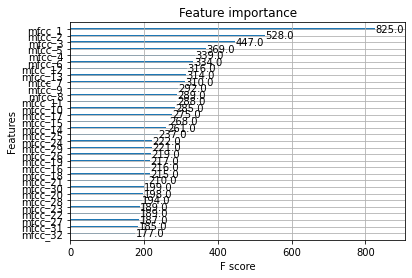

In [26]:
xgboost.plot_importance(xgb_model)

In [27]:
y_pred = xgb_model.predict(X_test)
y_pred

array([3.13457  , 3.1408231, 2.9122076, ..., 3.2038863, 2.8517022,
       2.995553 ], dtype=float32)

In [32]:
y_test

0       3.7
1       2.9
2       2.3
3       4.4
4       1.6
       ... 
2688    3.0
2689    2.6
2690    3.4
2691    2.4
2692    3.2
Name: Valence, Length: 2693, dtype: float64

In [35]:
from sklearn.metrics import mean_squared_error

RMSE = mean_squared_error(y_test, y_pred,squared=False)
RMSE

0.4154218254610649

# Arousal 예측

In [36]:
X_train = train_df.drop(columns=['Unnamed: 0', 'SegmentId','time','Valence','Arousal','Emotion'])
y_train = train_df['Arousal']

X_test = test_df.drop(columns=['Unnamed: 0', 'SegmentId','time','Valence','Arousal','Emotion'])
y_test = test_df['Arousal']

xgb_model = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)

print(len(X_train), len(X_test))
xgb_model.fit(X_train,y_train)

10769 2693


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.08, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

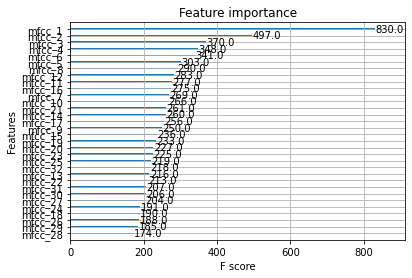

In [37]:
xgboost.plot_importance(xgb_model)

In [39]:
y_pred = xgb_model.predict(X_test)
y_pred

array([3.4559784, 3.2977479, 3.0534055, ..., 3.083681 , 2.9882128,
       3.001113 ], dtype=float32)

In [40]:
y_test

0       3.5
1       3.4
2       3.0
3       4.2
4       3.2
       ... 
2688    3.0
2689    3.2
2690    3.4
2691    2.6
2692    3.3
Name: Arousal, Length: 2693, dtype: float64

In [41]:
from sklearn.metrics import mean_squared_error

RMSE = mean_squared_error(y_test, y_pred,squared=False)
RMSE

0.22135961175392882